# Classification for High-Risk Individuals
## Medical Insurance Risk Prediction Project

### 📋 Project Overview
This notebook implements a comprehensive machine learning solution to **predict high-risk individuals** in medical insurance using a dataset of 100,000 insurance records with 54+ features. The goal is to identify individuals who are likely to incur high medical costs.

---

### 🎯 Objectives
1. **Exploratory Data Analysis (EDA)**: Understand the distribution of high-risk individuals and identify key factors contributing to risk
2. **Feature Engineering**: Create meaningful features from existing data to improve model performance
3. **Model Development**: Train and compare multiple classification models
4. **Model Evaluation**: Assess model performance using various metrics and select the best-performing model
5. **Feature Importance Analysis**: Identify the most influential factors in predicting high-risk status

---

### 🔬 Methodology

#### 1. **Data Preprocessing**
- Handle missing values (imputation using mean/mode)
- Remove duplicate records
- Encode categorical variables
- Scale numerical features for consistent model input

#### 2. **Exploratory Data Analysis**
- **Demographics**: Age, gender, urban/rural distribution by risk level
- **Lifestyle Factors**: BMI, smoking habits, alcohol frequency, exercise patterns
- **Clinical Features**: Blood pressure, cholesterol (LDL), HbA1c, chronic disease counts
- **Healthcare Utilization**: Hospitalizations, medication counts, procedures

#### 3. **Feature Engineering**
- Created **blood pressure difference** (systolic - diastolic)
- Calculated **dependents ratio** (dependents / household size)
- Categorized **BMI levels** (Underweight, Normal, Overweight, Obese)
- Applied **standardization** to numerical features for model compatibility

#### 4. **Model Training & Comparison**
We trained and evaluated **two classification models**:

| Model | Algorithm | Key Characteristics |
|-------|-----------|---------------------|
| **Logistic Regression** | Linear classifier | Fast, interpretable, works well with scaled features |
| **Random Forest** | Ensemble of decision trees | Handles non-linear relationships, feature importance available |

Both models use:
- **Stratified train-test split** (80/20) to maintain class distribution
- **Class balancing** to handle imbalanced high-risk vs. low-risk classes
- **Pipeline architecture** with preprocessing for clean model deployment

#### 5. **Evaluation Metrics**
- **Classification Report**: Precision, Recall, F1-Score for both classes
- **ROC-AUC Score**: Overall model performance (higher is better)
- **Confusion Matrix**: Visual representation of prediction accuracy
- **Feature Importance**: Identify key predictors (Random Forest only)

---

### 📊 Key Insights Expected
- Which demographic, lifestyle, and clinical factors most strongly predict high-risk status?
- How well can machine learning models identify high-risk individuals before they incur high costs?
- Which model provides the best balance between accuracy and interpretability?

---

### 🚀 Business Impact
This predictive model enables insurance providers to:
- **Proactively manage risk** by identifying high-risk individuals early
- **Personalize interventions** based on feature importance analysis
- **Optimize resource allocation** for preventive care programs
- **Improve customer outcomes** through targeted health management

---

### Import libraries

In [24]:
# Core Libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Styling
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
COLORS = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E']

# Machine Learning Models Classifiers
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score


# Statistical Analysis
from scipy import stats
from scipy.stats import pearsonr

print("✅ All libraries imported successfully!")
print(f"📦 Pandas version: {pd.__version__}")
print(f"📦 NumPy version: {np.__version__}")
print(f"📊 Dataset: 100,000 Insurance Records | 54+ Features")

✅ All libraries imported successfully!
📦 Pandas version: 2.2.2
📦 NumPy version: 1.26.4
📊 Dataset: 100,000 Insurance Records | 54+ Features


### Load the Dataset

In [9]:
df=pd.read_csv('medical_insurance_cleaned.csv')
print("Rows:", df.shape[0], "Columns:", df.shape[1])
df.head()

Rows: 100000 Columns: 54


,person_id,age,sex,region,urban_rural,income,education,marital_status,employment_status,household_size,...,liver_disease,arthritis,mental_health,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure
0,75722,52,Female,North,Suburban,22700,Doctorate,Married,Retired,3,...,0,1,0,1,0,2,0,1,0,0
1,80185,79,Female,North,Urban,12800,No HS,Married,Employed,3,...,0,1,1,0,0,1,0,1,1,0
2,19865,68,Male,North,Rural,40700,HS,Married,Retired,5,...,0,0,1,1,0,2,1,0,1,0
3,76700,15,Male,North,Suburban,15600,Some College,Married,Self-employed,5,...,0,0,0,1,0,0,1,0,0,0
4,92992,53,Male,Central,Suburban,89600,Doctorate,Married,Self-employed,2,...,0,1,0,2,0,1,1,0,1,0


### Data Preprocessing

In [10]:
# Check for missing values
print("\nMissing values per column:\n", df.isnull().sum())

# For numerical columns, fill with mean
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

# For categorical columns, fill with mode
cat_cols = df.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Drop duplicates if any
df.drop_duplicates(inplace=True)
print("\n✅ Missing values handled & duplicates removed!")


Missing values per column:
 person_id                      0
age                            0
sex                            0
region                         0
urban_rural                    0
income                         0
education                      0
marital_status                 0
employment_status              0
household_size                 0
dependents                     0
bmi                            0
smoker                         0
alcohol_freq                   0
visits_last_year               0
hospitalizations_last_3yrs     0
days_hospitalized_last_3yrs    0
medication_count               0
systolic_bp                    0
diastolic_bp                   0
ldl                            0
hba1c                          0
plan_type                      0
network_tier                   0
deductible                     0
copay                          0
policy_term_years              0
policy_changes_last_2yrs       0
provider_quality               0
risk_score    

### EDA

#### Target Variable Overview

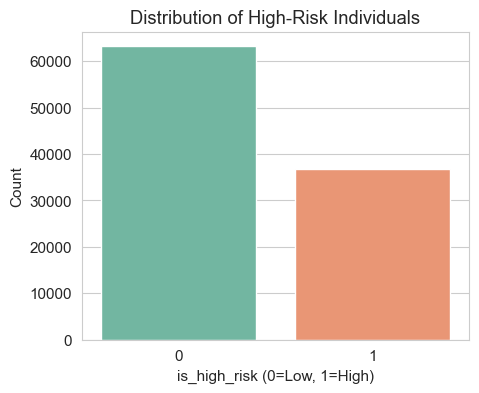

is_high_risk
0    63.219
1    36.781
Name: proportion, dtype: float64


In [13]:
# Target distribution
plt.figure(figsize=(5,4))
sns.countplot(x='is_high_risk', data=df, palette='Set2')
plt.title("Distribution of High-Risk Individuals")
plt.xlabel("is_high_risk (0=Low, 1=High)")
plt.ylabel("Count")
plt.show()

# Percentage
risk_counts = df['is_high_risk'].value_counts(normalize=True) * 100
print(risk_counts)


#### Demographics Insights

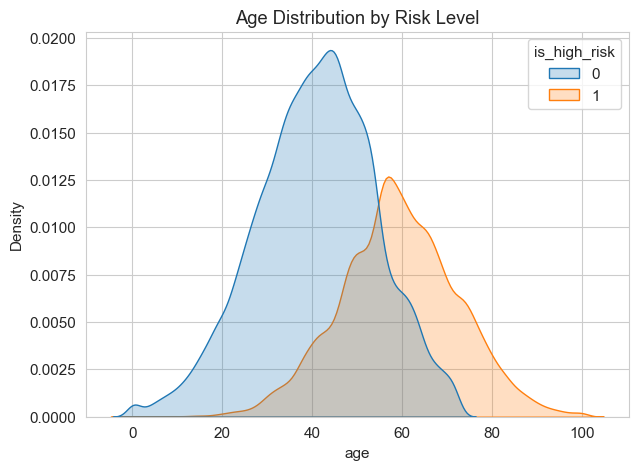

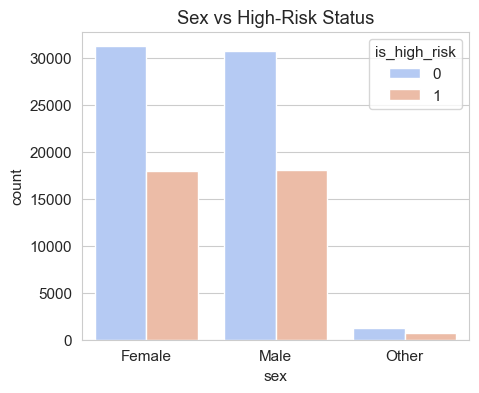

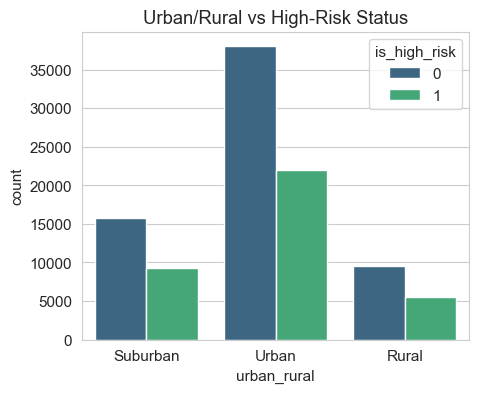

In [12]:
# Age distribution by risk
plt.figure(figsize=(7,5))
sns.kdeplot(data=df, x='age', hue='is_high_risk', fill=True)
plt.title("Age Distribution by Risk Level")
plt.show()

# Gender distribution
plt.figure(figsize=(5,4))
sns.countplot(x='sex', hue='is_high_risk', data=df, palette='coolwarm')
plt.title("Sex vs High-Risk Status")
plt.show()

# Urban vs Rural
plt.figure(figsize=(5,4))
sns.countplot(x='urban_rural', hue='is_high_risk', data=df, palette='viridis')
plt.title("Urban/Rural vs High-Risk Status")
plt.show()


#### Lifestyle Factors

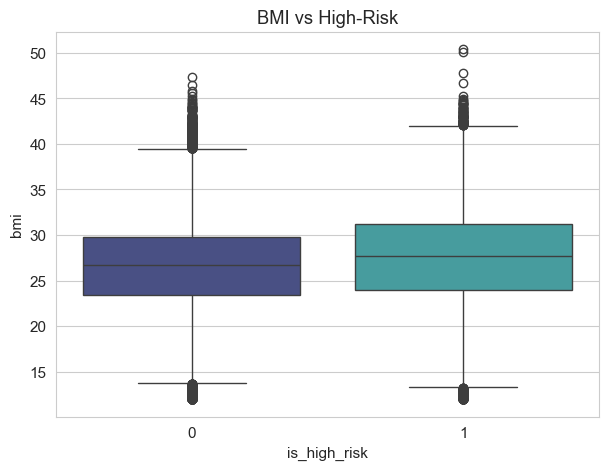

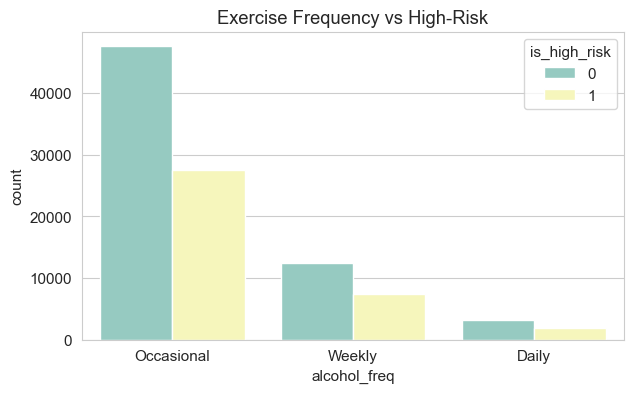

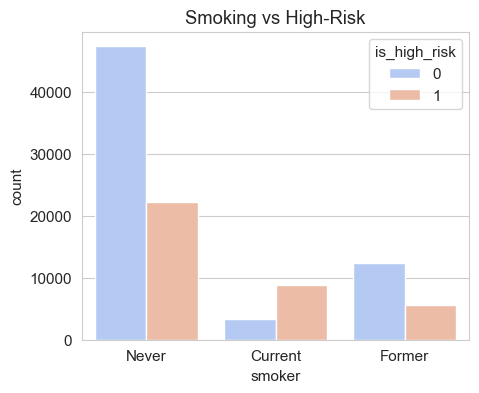

In [15]:
# BMI distribution
plt.figure(figsize=(7,5))
sns.boxplot(x='is_high_risk', y='bmi', data=df, palette='mako')
plt.title("BMI vs High-Risk")
plt.show()

# Exercise frequency vs risk
plt.figure(figsize=(7,4))
sns.countplot(x='alcohol_freq', hue='is_high_risk', data=df, palette='Set3')
plt.title("Exercise Frequency vs High-Risk")
plt.show()

# Smoking habit
plt.figure(figsize=(5,4))
sns.countplot(x='smoker', hue='is_high_risk', data=df, palette='coolwarm')
plt.title("Smoking vs High-Risk")
plt.show()


#### Clinical Features

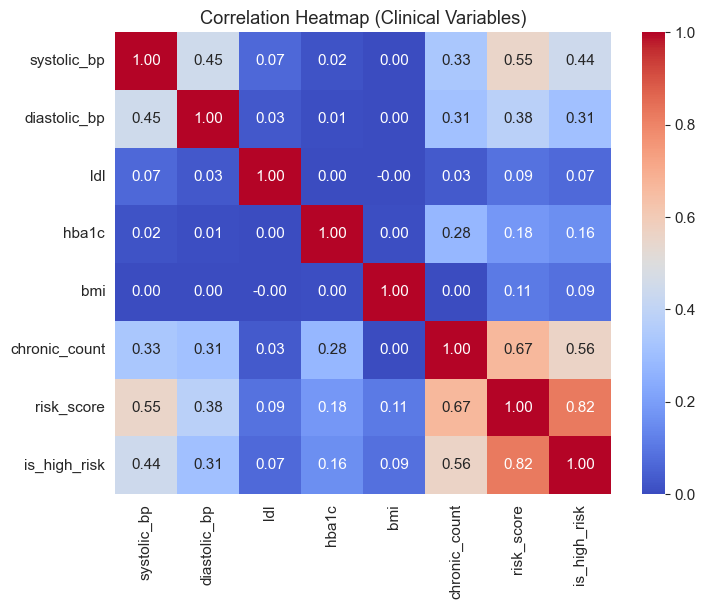

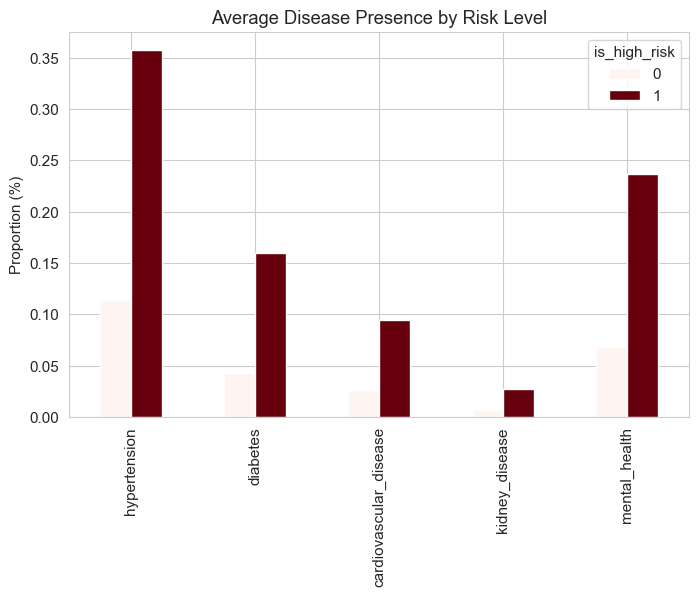

In [17]:
# Correlation of key numeric clinical variables
clinical_vars = ['systolic_bp', 'diastolic_bp', 'ldl', 'hba1c', 'bmi', 'chronic_count', 'risk_score']
corr = df[clinical_vars + ['is_high_risk']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (Clinical Variables)")
plt.show()

# Compare disease counts
disease_cols = ['hypertension', 'diabetes', 'cardiovascular', 'kidney_disease', 'mental_health']
disease_cols_corrected = ['hypertension', 'diabetes', 'cardiovascular_disease', 'kidney_disease', 'mental_health']
disease_risk = df.groupby('is_high_risk')[disease_cols_corrected].mean().T

disease_risk.plot(kind='bar', figsize=(8,5), colormap='Reds')
plt.title("Average Disease Presence by Risk Level")
plt.ylabel("Proportion (%)")
plt.show()

#### Healthcare Utilization

In [ ]:
# Hospitalizations vs risk
plt.figure(figsize=(7,5))
sns.boxplot(x='is_high_risk', y='hospitalizations_last_3yrs', data=df, palette='Blues')
plt.title("Hospitalizations in Last 3 Years vs Risk")
plt.show()

# Medication count
plt.figure(figsize=(7,5))
sns.boxplot(x='is_high_risk', y='medication_count', data=df, palette='Purples')
plt.title("Medication Count vs Risk")
plt.show()

#### Correlation Overview

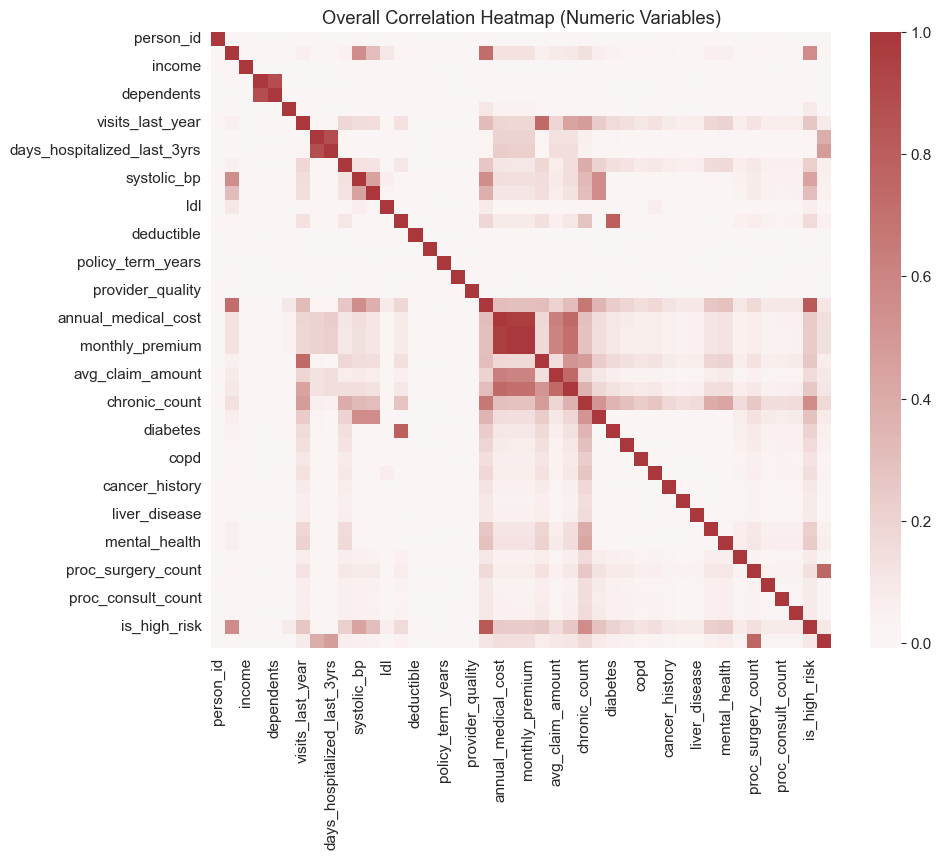

In [18]:
# Compute full correlation matrix (numeric only)
num_corr = df.select_dtypes(include=np.number).corr()
plt.figure(figsize=(10,8))
sns.heatmap(num_corr, cmap='vlag', center=0)
plt.title("Overall Correlation Heatmap (Numeric Variables)")
plt.show()

#### Feature Engineering & Model Preparation

In [19]:
target = 'is_high_risk'
X = df.drop(columns=[target, 'person_id'])
y = df[target]

# Identify feature types
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object', 'category']).columns

print(f"Numerical Features: {len(num_features)}")
print(f"Categorical Features: {len(cat_features)}")

# Encode categorical variables
label_enc = LabelEncoder()
for col in cat_cols:
    df[col] = label_enc.fit_transform(df[col].astype(str))

# Create new features 
# Difference between systolic and diastolic blood pressure
df['bp_diff'] = df['systolic_bp'] - df['diastolic_bp']

# Ratio of dependents to household size
df['dependents_ratio'] = np.where(df['household_size'] != 0,
                                  df['dependents'] / df['household_size'],
                                  0)

# BMI category (optional, can be used for analysis)
df['bmi_category'] = pd.cut(df['bmi'],
                            bins=[0, 18.5, 25, 30, 100],
                            labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# Encode the new categorical BMI category
df['bmi_category'] = label_enc.fit_transform(df['bmi_category'].astype(str))

# Scale numerical features
scaler = StandardScaler()
scale_cols = ['bmi', 'income', 'systolic_bp', 'diastolic_bp', 'ldl', 'hba1c', 'annual_medical_cost']
df[scale_cols] = scaler.fit_transform(df[scale_cols])

# Check engineered features
print("✅ Feature Engineering complete.")
print("New columns added: ['bp_diff', 'dependents_ratio', 'bmi_category']")
print("Scaled columns:", scale_cols)
df.head()


Numerical Features: 42
Categorical Features: 10
✅ Feature Engineering complete.
New columns added: ['bp_diff', 'dependents_ratio', 'bmi_category']
Scaled columns: ['bmi', 'income', 'systolic_bp', 'diastolic_bp', 'ldl', 'hba1c', 'annual_medical_cost']


,person_id,age,sex,region,urban_rural,income,education,marital_status,employment_status,household_size,...,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure,bp_diff,dependents_ratio,bmi_category
0,75722,52,0,2,1,-0.580639,1,1,1,3,...,1,0,2,0,1,0,0,45,0.333333,2
1,80185,79,0,2,2,-0.792178,4,1,0,3,...,0,0,1,0,1,1,0,52,0.333333,2
2,19865,68,1,2,0,-0.196024,2,1,1,5,...,1,0,2,1,0,1,0,76,0.600000,1
3,76700,15,1,2,1,-0.732349,5,1,2,5,...,1,0,0,1,0,0,0,36,0.600000,1
4,92992,53,1,0,1,0.848849,1,1,2,2,...,2,0,1,1,0,1,0,53,0.000000,1


### Model Training

In [27]:
# Preprocessor
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

# Split data first
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Model 1: Logistic Regression
print("Training Logistic Regression...")
lr_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight='balanced'
    ))
])
lr_model.fit(X_train, y_train)
print("✅ Logistic Regression training completed!")

# Model 2: Random Forest Classifier
print("\nTraining Random Forest...")
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight='balanced'
    ))
])
rf_model.fit(X_train, y_train)
print("✅ Random Forest training completed!")

print("\n✅ All models trained successfully!")

Training Logistic Regression...
✅ Logistic Regression training completed!

Training Random Forest...
✅ Logistic Regression training completed!

Training Random Forest...
✅ Random Forest training completed!

✅ All models trained successfully!
✅ Random Forest training completed!

✅ All models trained successfully!


### Model Evaluation

LOGISTIC REGRESSION EVALUATION
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     12644
           1       1.00      1.00      1.00      7356

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

ROC-AUC: 1.0000

RANDOM FOREST EVALUATION
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     12644
           1       1.00      1.00      1.00      7356

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

ROC-AUC: 1.0000

MODEL COMPARISON SUMMARY
Logistic Regression ROC-AUC: 1.0000
Random Forest ROC-AUC: 1.0000
Best Model: Random Forest
Classification Report:
               precision    recall  f1-score   support

           0

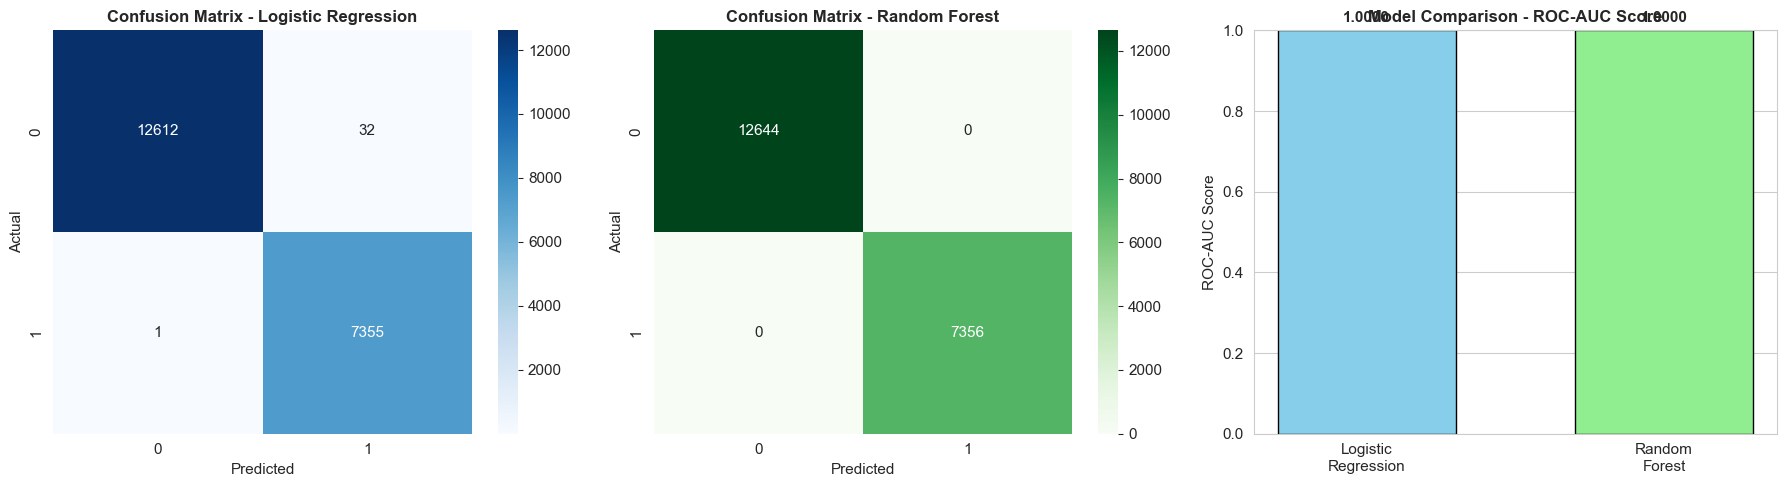

In [28]:
# Logistic Regression Evaluation
print("=" * 60)
print("LOGISTIC REGRESSION EVALUATION")
print("=" * 60)
lr_pred = lr_model.predict(X_test)
lr_prob = lr_model.predict_proba(X_test)[:,1]

print("Classification Report:\n", classification_report(y_test, lr_pred))
lr_roc_auc = roc_auc_score(y_test, lr_prob)
print(f"ROC-AUC: {lr_roc_auc:.4f}")

# Random Forest Evaluation
print("\n" + "=" * 60)
print("RANDOM FOREST EVALUATION")
print("=" * 60)
rf_pred = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)[:,1]

print("Classification Report:\n", classification_report(y_test, rf_pred))
rf_roc_auc = roc_auc_score(y_test, rf_prob)
print(f"ROC-AUC: {rf_roc_auc:.4f}")

# Model Comparison Summary
print("\n" + "=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)
print(f"Logistic Regression ROC-AUC: {lr_roc_auc:.4f}")
print(f"Random Forest ROC-AUC: {rf_roc_auc:.4f}")
print(f"Best Model: {'Random Forest' if rf_roc_auc > lr_roc_auc else 'Logistic Regression'}")

# Visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Confusion Matrix - Logistic Regression
cm_lr = confusion_matrix(y_test, lr_pred)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Confusion Matrix - Logistic Regression", fontsize=12, fontweight='bold')
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Confusion Matrix - Random Forest
cm_rf = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title("Confusion Matrix - Random Forest", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

# ROC-AUC Comparison
models = ['Logistic\nRegression', 'Random\nForest']
roc_scores = [lr_roc_auc, rf_roc_auc]
colors = ['skyblue', 'lightgreen']

axes[2].bar(models, roc_scores, color=colors, edgecolor='black', width=0.6)
axes[2].set_title('Model Comparison - ROC-AUC Score', fontsize=12, fontweight='bold')
axes[2].set_ylabel('ROC-AUC Score')
axes[2].set_ylim([0, 1])

for i, v in enumerate(roc_scores):
    axes[2].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

### Feature Importance

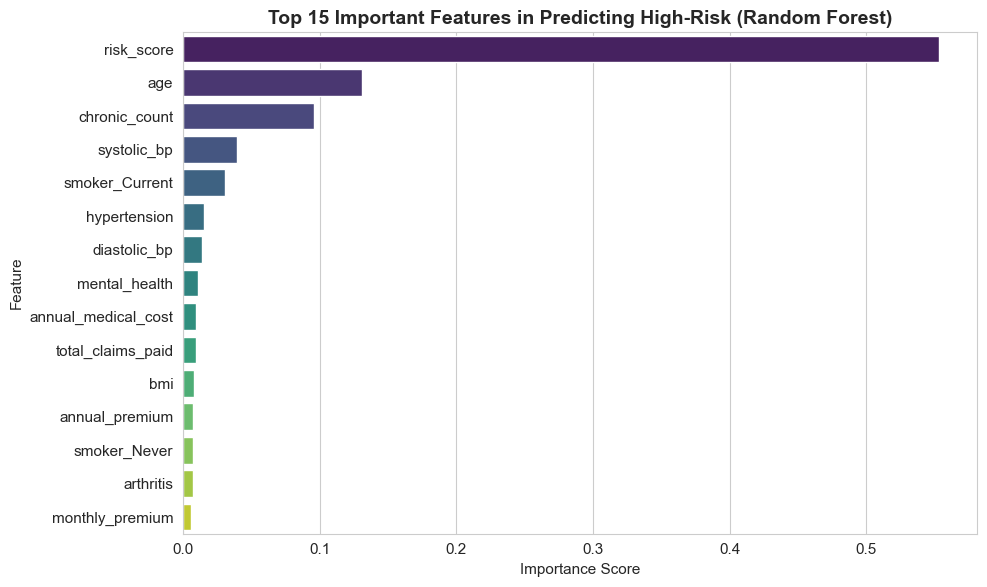

In [29]:
# Feature Importance - Random Forest only (Logistic Regression uses coefficients)
rf_classifier = rf_model.named_steps['classifier']
encoded_cat_features = rf_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(cat_features)
all_feature_names = np.concatenate([num_features, encoded_cat_features])

importances = pd.Series(rf_classifier.feature_importances_, index=all_feature_names).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=importances.head(15).values, y=importances.head(15).index, palette='viridis')
plt.title("Top 15 Important Features in Predicting High-Risk (Random Forest)", fontsize=14, fontweight='bold')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()